# ERA5 soil temperature and moisture

In [1]:
import os
import sys
import yaml
import dask
import zarr
import numpy as np
import xesmf as xe
import xarray as xr
import pandas as pd
from glob import glob
from dask.utils import SerializableLock

import calendar
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu

In [2]:
# import multiprocessing
# from dask.distributed import Client
# from dask_jobqueue import PBSCluster

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## ARCO ERA5
* Hourly data from `gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3`
* Accumulate hourly to 6 hourly: `xarray.resample(time='6h').sum()`

In [4]:
static_WRF_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_WRF_static = xr.open_zarr(static_WRF_name)
XLAT = ds_WRF_static['XLAT'].values
XLONG = ds_WRF_static['XLONG'].values
ds_WRF_static = ds_WRF_static.assign_coords(lat=(("south_north", "west_east"), XLAT))
ds_WRF_static = ds_WRF_static.assign_coords(lon=(("south_north", "west_east"), XLONG))
domain_inds = np.arange(336).astype(np.float32)
# 1000.,  950.,  850.,  700.,  600.,  500.,  400.,  300.,  200.,  100., 50.
ind_pick = [36, 34, 30, 25, 23, 21, 19, 17, 14, 10, 8]

In [5]:
fn_static = '/glade/campaign/cisl/aiml/ksha/CREDIT_data/ERA5_plevel_base/static/ERA5_plevel_6h_static.zarr'
ds_ERA5_static = xr.open_zarr(fn_static)

In [6]:
land_mask = ds_ERA5_static['land_sea_mask']

In [7]:
year = 1979

config_name = os.path.realpath('data_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [8]:
varnames = ['soil_temperature_level_1', 'volumetric_soil_water_layer_1']

# save to zarr
base_dir = conf['ARCO']['save_loc'] + 'land/' 
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)


chunk_size_3d = dict(chunks=(4, 336, 336))

dict_encoding = {}

for i_var, var in enumerate(varnames):
    dict_encoding[var] = {'compressor': compress, **chunk_size_3d}

In [9]:
ERA5_1h = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token='anon'),)[varnames]

time_start = '{}-01-01T00'.format(year)
time_end = '{}-12-31T23'.format(year)

ds = ERA5_1h.sel(time=slice(time_start, time_end))
ds = ds.where(land_mask != 0)

# ======================================================== #
# Interpolation block
ds['longitude'] = (ds['longitude']  + 180) % 360 - 180
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

regridder = xe.Regridder(ds, ds_WRF_static, method='bilinear') # extrap_method='nearest_s2d'

ds_ERA5_interp = regridder(ds)

ds_ERA5_interp = ds_ERA5_interp.assign_coords(
    south_north=domain_inds, 
    west_east=domain_inds
)

ds_ERA5_interp = ds_ERA5_interp.drop_vars(['lon', 'lat'])

In [24]:
st = ds_ERA5_interp['soil_temperature_level_1'].isel(time=999).values
sw = ds_ERA5_interp['volumetric_soil_water_layer_1'].isel(time=999).values

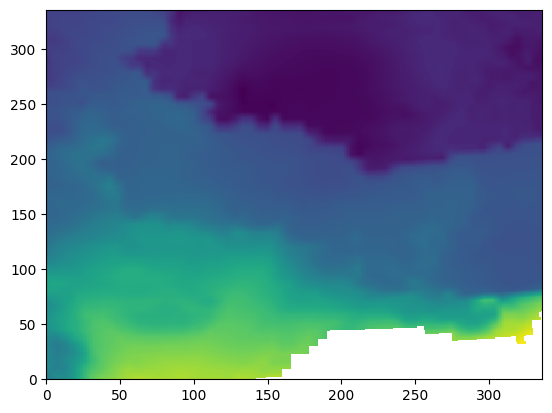

In [25]:
plt.pcolormesh(st)

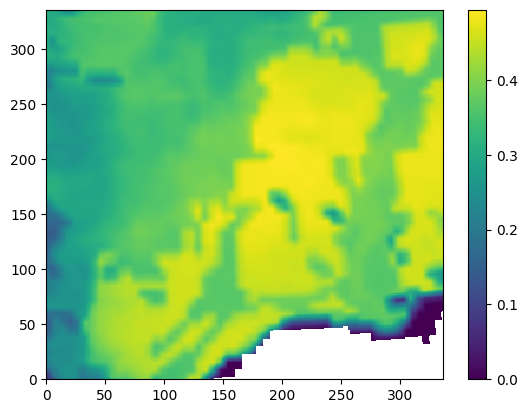

In [26]:
plt.pcolormesh(sw)
plt.colorbar()

In [7]:
save_name = base_dir + conf['ARCO']['prefix'] + '_land_{}.zarr'.format(year)

In [12]:
#ds_ERA5_interp.to_zarr(save_name, mode="w", consolidated=True, compute=True, encoding=dict_encoding)

In [8]:
save_name

'/glade/campaign/ral/hap/ksha/ERA5_data/land/ERA5_plevel_1h_land_1979.zarr'

In [14]:
xr.open_zarr(save_name)

<xarray.Dataset>
Dimensions:                        (time: 8760, south_north: 336, west_east: 336)
Coordinates:
  * south_north                    (south_north) float32 0.0 1.0 ... 334.0 335.0
  * time                           (time) datetime64[ns] 1979-01-01 ... 1979-...
  * west_east                      (west_east) float32 0.0 1.0 ... 334.0 335.0
Data variables:
    soil_temperature_level_1       (time, south_north, west_east) float32 dask.array<chunksize=(4, 336, 336), meta=np.ndarray>
    volumetric_soil_water_layer_1  (time, south_north, west_east) float32 dask.array<chunksize=(4, 336, 336), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

**Comparing accumulated hourly to the old directly available 6 hourly data**

In [15]:
ERA5_6h = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr",
    chunks=None,
    storage_options=dict(token='anon'),)

tp_6h_ref = ERA5_6h['total_precipitation_6hr']
tp_6h_ref = tp_6h_ref.sel(time=slice(time_start_save, time_end))

In [18]:
for ind_check in range(3):
    diff = np.sum(np.array(ERA5_6h_save['total_precipitation'].isel(time=ind_check)) - \
                  np.array(tp_6h_ref.isel(time=ind_check)))
    print(diff)

0.0
0.0
0.0


### Static variables

**ARCO**

* Hourly data from `gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3`

In [11]:
config_name = os.path.realpath('data_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [12]:
# save to zarr
base_dir = conf['ARCO']['save_loc'] + 'static/' 
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

dict_encoding = {}

for i_var, var in enumerate(conf['ARCO']['varname_static']):
    dict_encoding[var] = {'compressor': compress}

In [13]:
ERA5_1h = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token='anon'),)

ERA5_1h_slice = ERA5_1h.sel(time='2000-01-01T00')

variables_levels = {}
for varname in conf['ARCO']['varname_static']:
    variables_levels[varname] = None

ERA5_static = vu.ds_subset_everything(ERA5_1h_slice, variables_levels)

In [20]:
# normalize 'geopotential_at_surface'
mean_val = float(ERA5_static['geopotential_at_surface'].mean(skipna=False))
std_val = float(ERA5_static['geopotential_at_surface'].std(skipna=False))
ERA5_static['z_norm'] = (ERA5_static['geopotential_at_surface'] - mean_val)/std_val

# normalize soil type
ERA5_static['soil_type'] = ERA5_static['soil_type'] / 7

# fix coordiante names
ds_example = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_base/all_in_one/ERA5_plevel_6h_1979.zarr')
ERA5_static['latitude'] = ds_example['latitude']
ERA5_static['longitude'] = ds_example['longitude']
ERA5_static = ERA5_static.drop_vars('time')

save_name = base_dir + conf['ARCO']['prefix'] + '_static.zarr'
# ERA5_static.to_zarr(save_name, mode="w", consolidated=True, compute=True, encoding=dict_encoding)

In [23]:
save_name

'/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_base/static/ERA5_plevel_6h_static.zarr'

**Add coslat variable**

In [19]:
# base_dir = conf['ARCO']['save_loc'] + 'static/' 
# save_name = base_dir + conf['ARCO']['prefix'] + '_static.zarr'
# ERA5_static = xr.open_zarr(save_name)

In [25]:
# ERA5_static['geopotential_at_surface']
# ERA5_static['z_norm']

**Add mean and std to their files**

In [27]:
# mean_path = conf['ARCO']['save_loc'] + 'mean_std/mean_6h_1979_2019_13lev_0.25deg.nc'
# std_path = conf['ARCO']['save_loc'] + 'mean_std/std_residual_6h_1979_2019_13lev_0.25deg.nc'

# ds_mean = xr.open_dataset(mean_path)
# ds_mean['z_norm'] = mean_val

# ds_std = xr.open_dataset(std_path)
# ds_std['z_norm'] = std_val

# ds_mean.to_netcdf(mean_path, mode="w")
# ds_std.to_netcdf(std_path, mode="w")

## Others

### Total precipitation from RDA


```python
xr_ARCO = xr.open_zarr('/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_base/test_data/surf_test.zarr')
tp_ARCO = xr_ARCO['total_precipitation']

base_dir = '/glade/campaign/collections/rda/data/d633000/e5.oper.fc.sfc.accumu/197901/'
xr_RDA_CP = xr.open_dataset(base_dir+'e5.oper.fc.sfc.accumu.128_143_cp.ll025sc.1979010106_1979011606.nc')
xr_RDA_LP = xr.open_dataset(base_dir+'e5.oper.fc.sfc.accumu.128_142_lsp.ll025sc.1979010106_1979011606.nc')

xr_RDA_CP = xr_RDA_CP.drop_vars('utc_date', errors='ignore')
xr_RDA_CP = xr_RDA_CP.rename({'CP': 'TP'})
xr_RDA_LP = xr_RDA_LP.drop_vars('utc_date', errors='ignore')
xr_RDA_LP = xr_RDA_LP.rename({'LSP': 'TP'})

da = xr_RDA_CP + xr_RDA_LP

time_deltas = pd.to_timedelta(da["forecast_hour"].values, unit="h")
new_times = np.add.outer(da["forecast_initial_time"].values, time_deltas)
new_times = new_times.flatten()

da_an = da.stack(time=("forecast_initial_time", "forecast_hour"))
da_an = da_an.drop_vars(['forecast_hour', 'forecast_initial_time', 'time'])
da_an = da_an.assign_coords(time=new_times)

for i_hour in range(10):
    # i + 7 becuase ini_time = 06Z, fcst_lead_time starts from 01 hr
    tp_ARCO_np = np.array(tp_ARCO.isel(time=i_hour+7))
    da_np = np.array(da_an['TP'].isel(time=i_hour))
    print(np.sum(np.abs(tp_ARCO_np - da_np)))

# ARCO vs. RDA
data_var = da['TP']
tp_RDA = data_var.isel(forecast_initial_time=0)
tp_RDA_np = np.array(tp_RDA)
tp_ARCO_np = np.array(tp_ARCO.isel(time=slice(7, 7+12)))
np.sum(np.abs(tp_ARCO_np[3, ...] - tp_RDA_np[3, ...]))
```

### Combine Q components

In [4]:
config_name = os.path.realpath('data_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [12]:
year = 1989

chunk_size_4d = dict(chunks=(conf['zarr_opt']['chunk_size_4d']['time'],
                             conf['zarr_opt']['chunk_size_4d']['level'],
                             conf['zarr_opt']['chunk_size_4d']['latitude'],
                             conf['zarr_opt']['chunk_size_4d']['longitude']))

base_dir = conf['zarr_opt']['save_loc']
zarr_name_upper = sorted(glob(base_dir+'upper_air/ERA5_plevel_6h_upper_air_*.zarr'))
zarr_name_cloud = sorted(glob(base_dir+'cloud/*.zarr'))

fn_upper = [fn for fn in zarr_name_upper if str(year) in fn][0]
fn_cloud = [fn for fn in zarr_name_cloud if str(year) in fn][0]

variables_levels = {}
variables_levels['Q'] = None

ds_upper = xr.open_zarr(fn_upper).chunk(conf['zarr_opt']['chunk_size_4d'])
ds_upper = vu.ds_subset_everything(ds_upper, variables_levels)

ds_cloud = xr.open_zarr(fn_cloud).chunk(conf['zarr_opt']['chunk_size_4d'])

# ds_upper['Q'] = ds_upper['Q'] + ds_cloud['CLWC'] + ds_cloud['CRWC']
# + ds_cloud['CSWC'] +  ds_cloud['CIWC']

# ds_upper = ds_upper.rename({'Q': 'specific_total_water'})

dict_encoding = {}
compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)
dict_encoding['specific_total_water'] = {'compressor': compress, **chunk_size_4d}

save_name = base_dir+'upper_air/ERA5_plevel_6h_Q_{}.zarr'.format(year)
# ds_upper.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

In [10]:
base_dir

'/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_base/'

In [13]:
Q = np.array(ds_upper['Q'].isel(time=999))
CIWC = np.array(ds_cloud['CIWC'].isel(time=999))
CLWC = np.array(ds_cloud['CLWC'].isel(time=999))
CRWC = np.array(ds_cloud['CRWC'].isel(time=999))
CSWC = np.array(ds_cloud['CSWC'].isel(time=999))

In [42]:
i_level = -5
print(Q[i_level, ...].mean(), Q[i_level, ...].max())
print(CLWC[i_level, ...].mean(), CLWC[i_level, ...].max()) # 225 hPa level 15
print(CRWC[i_level, ...].mean(), CRWC[i_level, ...].max()) # 300 hPa level 17

0.005934408 0.019964522
2.2040711e-05 0.0011463165
2.2253564e-06 0.0015803277


In [35]:
levels = ds_upper['level'].values

### Combine all in one

In [29]:
year = 1979
base_dir = conf['zarr_opt']['save_loc']

In [30]:
zarr_name_surf = base_dir+'surf/ERA5_plevel_6h_surf_{}.zarr'
zarr_name_surf_extra = base_dir+'surf/ERA5_plevel_6h_surf_extend_{}.zarr'
zarr_name_accum = base_dir+'accum/ERA5_plevel_6h_accum_{}.zarr'
zarr_name_forcing = base_dir+'forcing/ERA5_plevel_6h_forcing_{}.zarr'
zarr_name_upper = base_dir+'upper_subset/ERA5_subset_6h_upper_air_{}.zarr'
zarr_name_upper_full = base_dir+'upper_air/ERA5_plevel_6h_upper_air_{}.zarr'
zarr_name_upper_Q = base_dir+'upper_air/ERA5_plevel_6h_Q_{}.zarr'
zarr_name_Q = base_dir+'upper_subset/ERA5_subset_6h_Q_{}.zarr'

In [31]:
ds_surf = xr.open_zarr(zarr_name_surf.format(year))
ds_surf_extra = xr.open_zarr(zarr_name_surf_extra.format(year))
ds_accum = xr.open_zarr(zarr_name_accum.format(year))
ds_forcing = xr.open_zarr(zarr_name_forcing.format(year))
ds_upper = xr.open_zarr(zarr_name_upper.format(year))
ds_upper_full = xr.open_zarr(zarr_name_upper_full.format(year))
ds_upper_Q = xr.open_zarr(zarr_name_upper_Q.format(year))
ds_Q = xr.open_zarr(zarr_name_Q.format(year))

ds_500hPa = xr.merge([ds_upper_full.isel(level=21), ds_upper_Q.isel(level=21)])

In [32]:
ds_500hPa = ds_500hPa.rename({'T': 'T500', 
                              'U': 'U500', 
                              'V': 'V500', 
                              'Z': 'Z500', 
                              'Q': 'Q500', 
                              'specific_total_water': 'specific_total_water_500'})

In [33]:
# combining land-sea mask and sea-ice cover

ds_static = xr.open_zarr(base_dir+'static/ERA5_plevel_6h_static.zarr')
land_sea_mask = ds_static['land_sea_mask']
sea_ice_cover = ds_surf_extra['CI']

land_sea_mask_expanded = land_sea_mask.broadcast_like(sea_ice_cover)
land_sea_CI_mask = xr.where(
    (land_sea_mask_expanded == 0) & (sea_ice_cover > 0),
    -sea_ice_cover,
    land_sea_mask_expanded
)

land_sea_CI_mask.name = 'land_sea_CI_mask'
ds_mask = land_sea_CI_mask.to_dataset()

In [34]:
ds_merge = xr.merge([ds_surf, ds_accum, ds_forcing, ds_upper, ds_Q, ds_mask, ds_500hPa])
ds_merge = ds_merge.drop_vars('SSTK')

In [36]:
varnames = list(ds_merge.keys())
varname_4D = ['U', 'V', 'T', 'Z', 'Q', 'specific_total_water']

for i_var, var in enumerate(varnames):
    if var in varname_4D:
        ds_merge[var] = ds_merge[var].chunk(conf['zarr_opt']['chunk_size_4d'])
    else:
        ds_merge[var] = ds_merge[var].chunk(conf['zarr_opt']['chunk_size_3d'])

In [37]:
# ========================================================================== #
# zarr encodings
dict_encoding = {}

chunk_size_3d = dict(chunks=(conf['zarr_opt']['chunk_size_3d']['time'],
                             conf['zarr_opt']['chunk_size_3d']['latitude'],
                             conf['zarr_opt']['chunk_size_3d']['longitude']))

chunk_size_4d = dict(chunks=(conf['zarr_opt']['chunk_size_4d']['time'],
                             conf['zarr_opt']['chunk_size_4d']['level'],
                             conf['zarr_opt']['chunk_size_4d']['latitude'],
                             conf['zarr_opt']['chunk_size_4d']['longitude']))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    if var in varname_4D:
        dict_encoding[var] = {'compressor': compress, **chunk_size_4d}
    else:
        dict_encoding[var] = {'compressor': compress, **chunk_size_3d}

In [38]:
save_name = base_dir+'all_in_one/ERA5_plevel_6h_{}.zarr'.format(year)
# ds_merge.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)